In [ ]:
!pip install tensorflow.keras
!pip install tensorflow

In [ ]:
!pip install opendatasets --quiet

import opendatasets as od
od.download("https://www.kaggle.com/datasets/pranavgautam29/chest-x-ray-imagesmultiple-diseases")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abdoelwahsh
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/pranavgautam29/chest-x-ray-imagesmultiple-diseases


Categories: ['Tuberculosis', 'Pneumothorax', 'Normal', 'Pneumonia', 'Covid']
Number of images per category: {'Tuberculosis': 700, 'Pneumothorax': 1012, 'Normal': 1118, 'Pneumonia': 1246, 'Covid': 377}


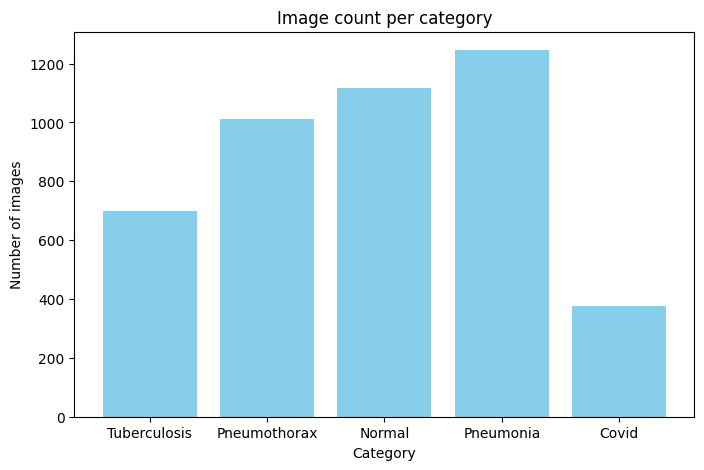

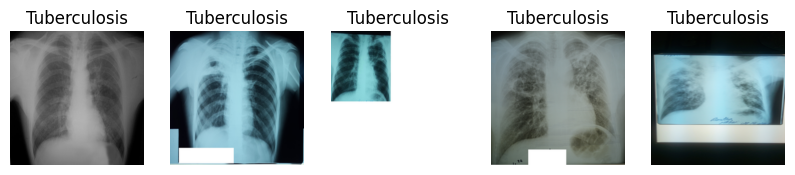

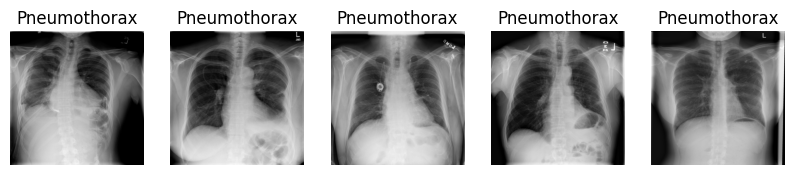

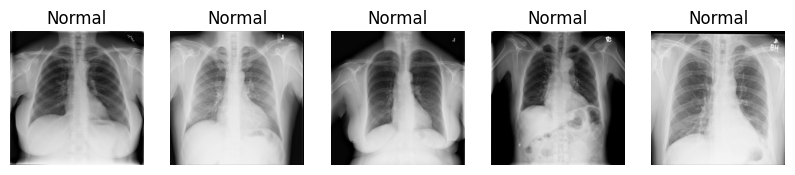

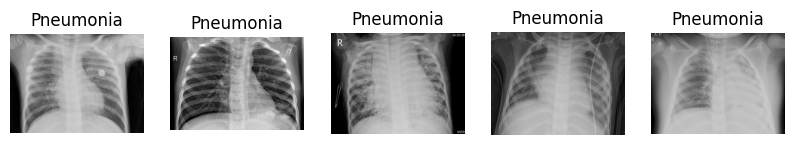

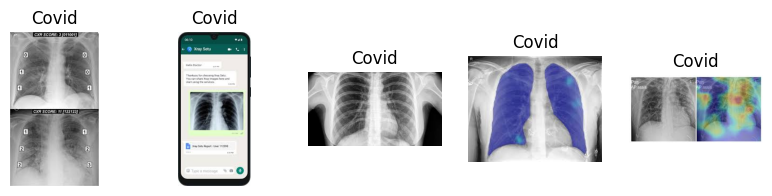

Average height: 723
Average width: 826


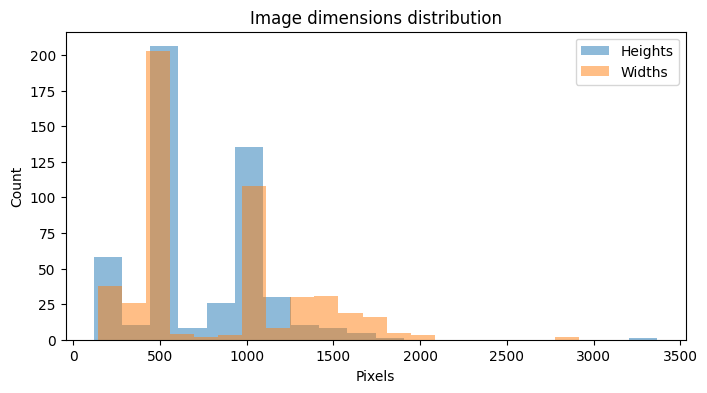

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# 1. Define the data directory
data_dir = './chest-x-ray-imagesmultiple-diseases/data'

# 2. List categories (folders)
categories = [cat for cat in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cat))]
print("Categories:", categories)

# 3. Count images in each category
class_counts = {}
for category in categories:
    category_path = os.path.join(data_dir, category)
    class_counts[category] = len([img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))])
print("Number of images per category:", class_counts)

# 4. Plot class distribution
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image count per category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.show()

# 5. Show sample images from each category
for category in categories:
    category_path = os.path.join(data_dir, category)
    images = [img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))]
    plt.figure(figsize=(10,2))
    shown = 0
    for img_name in images:
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1,5,shown+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(category)
            shown += 1
            if shown == 5:
                break
    plt.show()

# 6. Analyze image dimensions
heights = []
widths = []
for category in categories:
    category_path = os.path.join(data_dir, category)
    images = [img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))]
    for img_name in images[:100]:  # Analyze up to 100 images per category
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            heights.append(h)
            widths.append(w)

if heights and widths:
    print("Average height:", sum(heights)//len(heights))
    print("Average width:", sum(widths)//len(widths))
    plt.figure(figsize=(8,4))
    plt.hist(heights, bins=20, alpha=0.5, label='Heights')
    plt.hist(widths, bins=20, alpha=0.5, label='Widths')
    plt.legend()
    plt.title('Image dimensions distribution')
    plt.xlabel('Pixels')
    plt.ylabel('Count')
    plt.show()
else:
    print("No valid images found for dimension analysis.")

In [ ]:
# tensorflow.__version__

In [ ]:
import os
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# المسارات
data_dir = './chest-x-ray-imagesmultiple-diseases/data'
processed_dir = './processed_images'
img_size = (224, 224)

# 1. تحويل الصور إلى Grayscale + Resizing + Normalization
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    output_category_path = os.path.join(processed_dir, category)

    if not os.path.exists(output_category_path):
        os.makedirs(output_category_path)

    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is not None and len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, img_size)
                img = img / 255.0
                save_path = os.path.join(output_category_path, img_name)
                cv2.imwrite(save_path, (img * 255).astype('uint8'))

# 2. حساب عدد الصور في كل كلاس
class_counts = {}
for class_name in os.listdir(processed_dir):
    class_path = os.path.join(processed_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

print("Class counts before augmentation:", class_counts)

# 3. عمل Augmentation للكلاسات الأقل
max_count = max(class_counts.values())

augmentor = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

for class_name, count in class_counts.items():
    class_path = os.path.join(processed_dir, class_name)
    # Get the initial list of images BEFORE augmentation
    images = os.listdir(class_path)

    while len(os.listdir(class_path)) < max_count:
        img_name = random.choice(images)  # Choose from the original images
        img_path = os.path.join(class_path, img_name)

        # Check if it's a file to avoid the IsADirectoryError
        if os.path.isfile(img_path):
            img = load_img(img_path, color_mode='grayscale', target_size=img_size)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in augmentor.flow(x, batch_size=1, save_to_dir=class_path,
                                         save_prefix='aug', save_format='jpeg'):
                if len(os.listdir(class_path)) >= max_count:
                    break
        else:
            print(f"Skipping {img_path} as it's not a file.")

# 4. طباعة عدد الصور بعد التوازن
balanced_counts = {cls: len(os.listdir(os.path.join(processed_dir, cls))) for cls in os.listdir(processed_dir)}
print("Class counts after augmentation:", balanced_counts)

Class counts before augmentation: {'Tuberculosis': 700, 'Pneumothorax': 1012, 'Normal': 1118, 'Pneumonia': 1246, 'Covid': 370}
Class counts after augmentation: {'Tuberculosis': 1246, 'Pneumothorax': 1246, 'Normal': 1246, 'Pneumonia': 1246, 'Covid': 1246}


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# اختَر فئة موجودة عندك
category = 'Normal'  # يمكنك تغييرها لأي فئة أخرى

# ابحث عن أول صورة في مجلد البيانات الأصلي
original_dir = f'./chest-x-ray-imagesmultiple-diseases/data/{category}'
img_name = None
for file in os.listdir(original_dir):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_name = file
        break

if img_name is None:
    print("لم يتم العثور على صورة مناسبة في المجلد الأصلي.")
else:
    # المسار الأصلي
    original_path = os.path.join(original_dir, img_name)

    # ابحث عن الصورة بعد الـ preprocessing في مجلدات التقسيم
    processed_path = None
    for split in ['train', 'val', 'test']:
        candidate = f'./processed_images/{split}/{category}/{img_name}'
        if os.path.exists(candidate):
            processed_path = candidate
            break

    if processed_path is None:
        print("لم يتم العثور على الصورة بعد الـ preprocessing في أي مجلد من مجلدات التقسيم.")
    else:
        # قراءة الصور
        original_img = cv2.imread(original_path)
        processed_img = cv2.imread(processed_path, cv2.IMREAD_GRAYSCALE)

        # عرض الصور جنبًا إلى جنب
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(processed_img, cmap='gray')
        plt.title('Processed')
        plt.axis('off')

        plt.show()

        # طباعة معلومات عن الأبعاد
        print("Original shape:", original_img.shape)
        print("Processed shape:", processed_img.shape)

لم يتم العثور على الصورة بعد الـ preprocessing في أي مجلد من مجلدات التقسيم.


In [ ]:
import os
import random
import shutil

DATASET_DIR = './processed_images'  # مجلد الصور بعد الـ preprocessing
CLASSES = [cls for cls in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, cls))]
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

for cls in CLASSES:
    cls_dir = os.path.join(DATASET_DIR, cls)
    images = os.listdir(cls_dir)
    random.shuffle(images)
    n_total = len(images)
    n_train = int(n_total * TRAIN_RATIO)
    n_val = int(n_total * VAL_RATIO)
    n_test = n_total - n_train - n_val

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    # إنشاء مجلدات التقسيم
    train_cls_dir = os.path.join(DATASET_DIR, 'train', cls)
    val_cls_dir = os.path.join(DATASET_DIR, 'val', cls)
    test_cls_dir = os.path.join(DATASET_DIR, 'test', cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(val_cls_dir, exist_ok=True)
    os.makedirs(test_cls_dir, exist_ok=True)

    # نقل الصور
    for img in train_imgs:
        shutil.move(os.path.join(cls_dir, img), os.path.join(train_cls_dir, img))
    for img in val_imgs:
        shutil.move(os.path.join(cls_dir, img), os.path.join(val_cls_dir, img))
    for img in test_imgs:
        shutil.move(os.path.join(cls_dir, img), os.path.join(test_cls_dir, img))

In [ ]:
import tensorflow as tf
import os

DATASET_DIR = './processed_images'
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'val'),
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=123
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 4359 files belonging to 5 classes.
Found 930 files belonging to 5 classes.
Found 940 files belonging to 5 classes.
Classes: ['Covid', 'Normal', 'Pneumonia', 'Pneumothorax', 'Tuberculosis']


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ... existing code لتحميل البيانات ...

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    data_augmentation,  # طبقة augmentation في البداية
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import tensorflow as tf
# import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks=[
EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
),
             ModelCheckpoint(
        filepath='CNN_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    )
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4892 - loss: 1.4682
Epoch 1: val_loss improved from inf to 0.57034, saving model to CNN_best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 564s 4s/step - accuracy: 0.4902 - loss: 1.4646 - val_accuracy: 0.7419 - val_loss: 0.5703
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7695 - loss: 0.5598
Epoch 2: val_loss improved from 0.57034 to 0.50741, saving model to CNN_best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 577s 4s/step - accuracy: 0.7695 - loss: 0.5597 - val_accuracy: 0.7731 - val_loss: 0.5074
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7856 - loss: 0.5074
Epoch 3: val_loss improved from 0.50741 to 0.45510, saving model to CNN_best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.7857 - loss: 0.5073 - val_accuracy: 0.8065 - val_loss: 0.4551
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8026 - loss: 0.4557
Epoch 4: val_loss improved from 0.45510 to 

In [ ]:
history.save("cnn_model_1.h5")
print("Models saved.")

NameError: name 'history' is not defined

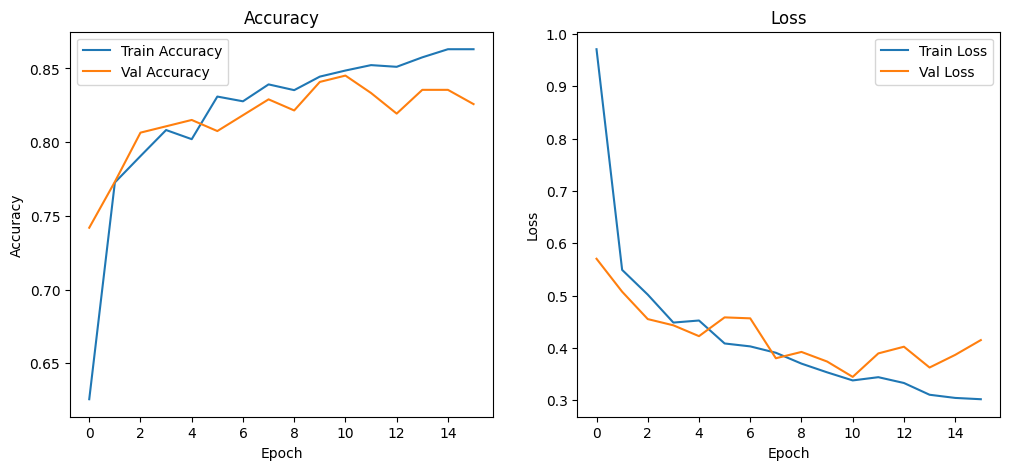

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# تقييم النموذج على test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# توقع الفئات على test set
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 952ms/step - accuracy: 0.8798 - loss: 0.2801
Test Accuracy: 0.86
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Abdulrhman basheer Mohammed model
import tensorflow
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMG_SIZE = 224
batch_size = 32
train_path = '/content/processed_images/train'
val_path = '/content/processed_images/val'
test_path = '/content/processed_images/test'

ResNet_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet50v2)
ResNet_train_generator = ResNet_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical')

FileNotFoundError: [Errno 2] No such file or directory: '/content/processed_images/train'

In [ ]:
ResNet_train_generator.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2, 'Pneumothorax': 3, 'Tuberculosis': 4}

In [ ]:
ResNet_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet50v2)
ResNet_val_generator = ResNet_val_datagen.flow_from_directory(
        val_path,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical')

Found 930 images belonging to 5 classes.


In [ ]:
ResNet_val_generator.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2, 'Pneumothorax': 3, 'Tuberculosis': 4}

In [ ]:
trained_ResNet_layers = ResNet50V2(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
for layer in trained_ResNet_layers.layers:
    layer.trainable = False

In [ ]:
import tensorflow as tf
from tensorflow import keras

ResNet_model = tensorflow.keras.models.Sequential([
    trained_ResNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(ResNet_val_generator.class_indices), activation='softmax')
])

In [ ]:
ResNet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,629 (91.90 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
import tensorflow
from tensorflow import keras
from keras import callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        filepath='ResNet_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    )
]

In [ ]:
ResNet_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [ ]:
ResNet_history = ResNet_model.fit(
        ResNet_train_generator,
        epochs = 30,
        validation_data = ResNet_val_generator,
        callbacks = callbacks
        )

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7587 - loss: 0.7313 - precision: 0.7966 - recall: 0.7249
Epoch 1: val_loss improved from inf to 0.28349, saving model to ResNet_best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 818s 6s/step - accuracy: 0.7592 - loss: 0.7294 - precision: 0.7971 - recall: 0.7254 - val_accuracy: 0.8753 - val_loss: 0.2835 - val_precision: 0.8937 - val_recall: 0.8495
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9037 - loss: 0.2476 - precision: 0.9186 - recall: 0.8913
Epoch 2: val_loss improved from 0.28349 to 0.28302, saving model to ResNet_best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 772s 6s/step - accuracy: 0.9038 - loss: 0.2475 - precision: 0.9186 - recall: 0.8913 - val_accuracy: 0.8806 - val_loss: 0.2830 - val_precision: 0.8959 - val_recall: 0.8699
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9030 - loss: 0.2164 - precision: 0.9159 - recall: 0.8960
Epoch 3: val_loss did not improve from 0.28302
137/137 ━━━━━━━━━━

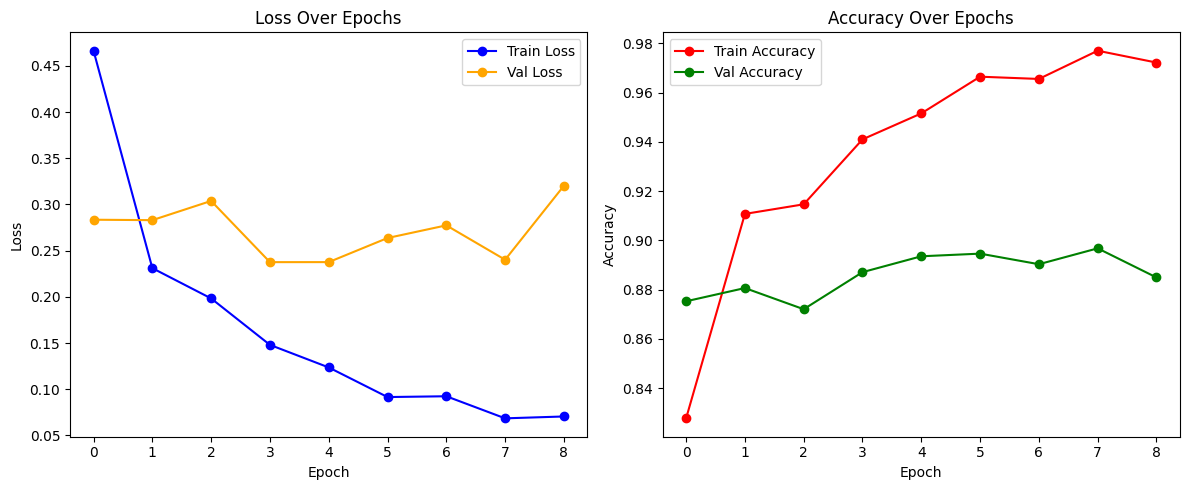

In [ ]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(ResNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(ResNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(ResNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(ResNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
ResNet_model.save("AbdoElwahsh_model_resnet.h5")
print("Models saved.")

Models saved.


In [ ]:
import tensorflow
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

MobileNet_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenetv2)
MobileNet_train_generator = MobileNet_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical')

Found 4359 images belonging to 5 classes.


In [ ]:
MobileNet_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenetv2)
MobileNet_val_generator = MobileNet_val_datagen.flow_from_directory(
        val_path,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical')

Found 930 images belonging to 5 classes.


In [ ]:
# mobilenet (abdulhameed):
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        filepath='MobileNet_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    )
]

In [ ]:
mobile_history = model.fit(
    MobileNet_train_generator,
    epochs = 30,
    validation_data = MobileNet_val_generator,
    callbacks = callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6102 - loss: 0.9882
Epoch 1: val_loss improved from inf to 0.31683, saving model to MobileNet_best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.6112 - loss: 0.9858 - val_accuracy: 0.8849 - val_loss: 0.3168
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8753 - loss: 0.3335
Epoch 2: val_loss improved from 0.31683 to 0.25741, saving model to MobileNet_best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8754 - loss: 0.3334 - val_accuracy: 0.9097 - val_loss: 0.2574
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9072 - loss: 0.2550
Epoch 3: val_loss improved from 0.25741 to 0.22772, saving model to MobileNet_best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9072 - loss: 0.2550 - val_accuracy: 0.9194 - val_loss: 0.2277
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9068 - loss: 0.2318
Epoch 4: val_loss improve

In [ ]:
import tensorflow
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception

xception_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_xception)
xception_train_generator = xception_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical')

NameError: name 'ImageDataGenerator' is not defined

In [ ]:
xception_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_xception)
xception_val_generator = ResNet_val_datagen.flow_from_directory(
        val_path,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models

xception_base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception_base.trainable = False  # Freeze base

model_xception = models.Sequential([
    xception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Match your class count
])

model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])